### Value iteration method

""" 
The overall logic of our code is simple: in the loop, we play 100
random steps from the environment, populating the reward and
transition tables. After those 100 steps, we perform a value iteration
loop over all states, updating our value table. Then we play several
full episodes to check our improvements using the updated value
table. If the average reward for those test episodes is above the 0.8
boundary, then we stop training. During the test episodes, we also
update our reward and transition tables to use all data from the
environment.
"""

In [13]:
import gym
import collections
from tensorboardX import SummaryWriter
ENV_NAME = "FrozenLake-v1"

In [41]:
# we define the Agent class, which will keep our tables and
# contain functions that we will be using in the training loop
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()[0]
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(collections.Counter) #transition table
        self.values = collections.defaultdict(float)  #value table

    def play_n_random_steps(self, count):
        for _ in range(count):
            action = self.env.action_space.sample()
            new_state, reward, is_done, _,_ = self.env.step(action)
            #self.rewards[(self.state, action, new_state)] = reward
            key = (self.state, action, new_state)
            self.rewards[key] = reward
            # The key is the composite "state" +"action", and the value is another dictionary that maps the
            # target state into a count of times that we have seen it.
            self.transits[(self.state, action)][new_state] += 1
            self.state = self.env.reset()[0] if is_done else new_state  

    def calc_action_value(self, state, action):
        target_counts = self.transits[(state, action)]
        total = sum(target_counts.values())
        action_value = 0.0
        for tgt_state, count in target_counts.items():
            reward = self.rewards[(state, action, tgt_state)]
            action_value += (count / total) * (reward + GAMMA * self.values[tgt_state])
        return action_value         

    def select_action(self, state):  # action with maximum action value
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.calc_action_value(state, action)
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action 

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()[0]
        while True:
            action = self.select_action(state)
            new_state, reward, is_done, _, _ = env.step(action)
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward

    def value_iteration(self):
        for state in range(self.env.observation_space.n):
            state_values = [self.calc_action_value(state, action)
                            for action in range(self.env.action_space.n)]
            self.values[state] = max(state_values)    

            


In [7]:
GAMMA = 0.9
TEST_EPISODES = 20

In [42]:
test_env = gym.make(ENV_NAME)
agent = Agent()

iter_no = 0
best_reward = 0.0
Rewards=[]
while True:
    iter_no += 1
    agent.play_n_random_steps(100)
    agent.value_iteration()

    reward = 0.0
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)
    reward /= TEST_EPISODES
    Rewards.append(reward)
    if reward > best_reward:
        print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
        best_reward = reward
    if reward > 0.80:
        print("Solved in %d iterations!" % iter_no)
        break

Best reward updated 0.000 -> 0.150
Best reward updated 0.150 -> 0.350
Best reward updated 0.350 -> 0.450
Best reward updated 0.450 -> 0.600
Best reward updated 0.600 -> 0.650
Best reward updated 0.650 -> 0.800
Best reward updated 0.800 -> 0.850
Solved in 18 iterations!


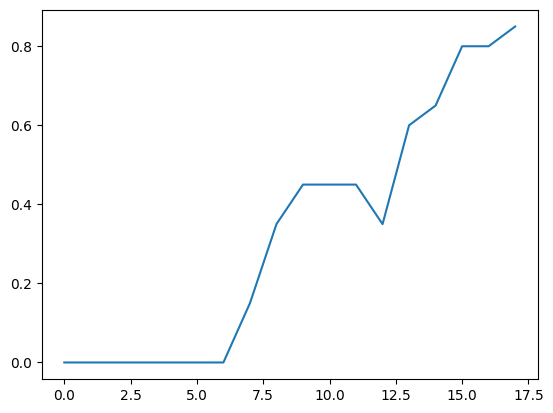

In [43]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(Rewards))],Rewards)